In [20]:
import h5py
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import glob
from biosppy.signals import tools as st
from scipy import stats

In [21]:
def scale(arr, m, s):
    arr -= m
    arr /= (s + 1e-7)
    return arr


def rescale(arr, m, s):
    arr = arr * s
    arr = arr + m
    return arr

def scale_minmax(arr, min, max):
    arr = (arr - min) / (max - min)
    return arr


def scale_maxabs(arr, maxabs):
    arr = arr / maxabs
    return arr


def scale_robust(arr, q1, q3):
    print('q1 : ', q1, 'q1 : ', q3)
    arr = (arr - q1) / (q3-q1)
    return arr


def scale_div(arr, denom):
    arr = arr / denom
    return arr

In [22]:
SCALER = 'raw'
DATAPATH = '../data/ecg/raw/2019-11-19'
ecg_key_string_list = [
    "strip_I",
    "strip_II",
    "strip_III",
    # "strip_aVR",
    # "strip_aVL",
    # "strip_aVF",
    # "strip_V1",
    # "strip_V2",
    # "strip_V3",
    # "strip_V4",
    # "strip_V5",
    # "strip_V6",
]

hdf5_files = []
count = 0
for f in glob.glob("{}/*.hd5".format(DATAPATH)):
    count += 1
    if count > 7000:
        break
    hdf5_files.append(f)

print('Data Loading finished (row:{})'.format(len(hdf5_files)))

Data Loading finished (row:7000)


In [23]:
x_all = []
y_all = []
for hdf_file in hdf5_files:
    f = h5py.File(hdf_file, 'r')
    y_all.append(f['continuous']['VentricularRate'][0])
    x_list = list()
    for (i, key) in enumerate(ecg_key_string_list):
        x = f['ecg_rest'][key][:]
        x_list.append(x)
    x_list = np.stack(x_list)
    x_list = x_list.reshape([3, 12 // 12, 500, 5000 // 500]).mean(3).mean(1)
    x_all.append(x_list)

x = np.asarray(x_all)
y = np.asarray(y_all)

for i in range(x.shape[1]):
    part_x = x[:, i, :]
    print('train_x m, s: ', part_x.mean(), part_x.std())
    print('train_x min, max: ', part_x.min(), part_x.max())

    if SCALER == 'minmax':
        part_x = scale_minmax(part_x, part_x.min(), part_x.max())
    elif SCALER == 'maxabs':
        part_x = scale_maxabs(part_x, np.max(np.abs(part_x)))
    elif SCALER == 'robust':
        part_x = scale_robust(part_x, np.quantile(part_x, 0.25), np.quantile(part_x, 0.75))
    elif SCALER == 'standard':
        part_x = scale(part_x, part_x.mean(), part_x.std())
    elif SCALER == 'div10':
        part_x = scale_div(part_x, 10)
    elif SCALER == 'div100':
        part_x = scale_div(part_x, 100)
    elif SCALER == 'fir':
        order = int(0.3 * 100)
        filtered, _, _ = st.filter_signal(signal=part_x,
                                          ftype='FIR',
                                          band='bandpass',
                                          order=order,
                                          frequency=[3, 45],
                                          sampling_rate=100)
        part_x = filtered



    x[:, i, :] = part_x


x = x.reshape(x.shape[0], -1)

train_x m, s:  11.006688 139.4843108811548
train_x min, max:  -5804.7 5647.9
train_x m, s:  1.6838974285714274 160.7995315050168
train_x min, max:  -6264.0 6124.8
train_x m, s:  -9.254726799999997 168.91505337686394
train_x min, max:  -5681.3 6559.4


In [24]:
x.shape

(7000, 1500)

In [44]:
# About outlier of X
for i in range(x.shape[0]):
    plt.plot(x[i, :])
    if (np.max(x[i, :]) > 2000):
        print('max', np.max(x[i, :]), 'i', i)

max 3053.2 i 169
max 5693.3 i 619
max 6559.4 i 868
max 6124.8 i 1291
max 3723.2 i 1338
max 3214.0 i 1422
max 2699.5 i 2933
max 3091.0 i 3602
max 5331.7 i 4530
max 2616.4 i 5224
max 2363.8 i 6065
max 5647.9 i 6321
max 3770.6 i 6856
max 4940.9 i 6995


In [45]:
plt.show()

<IPython.core.display.Javascript object>


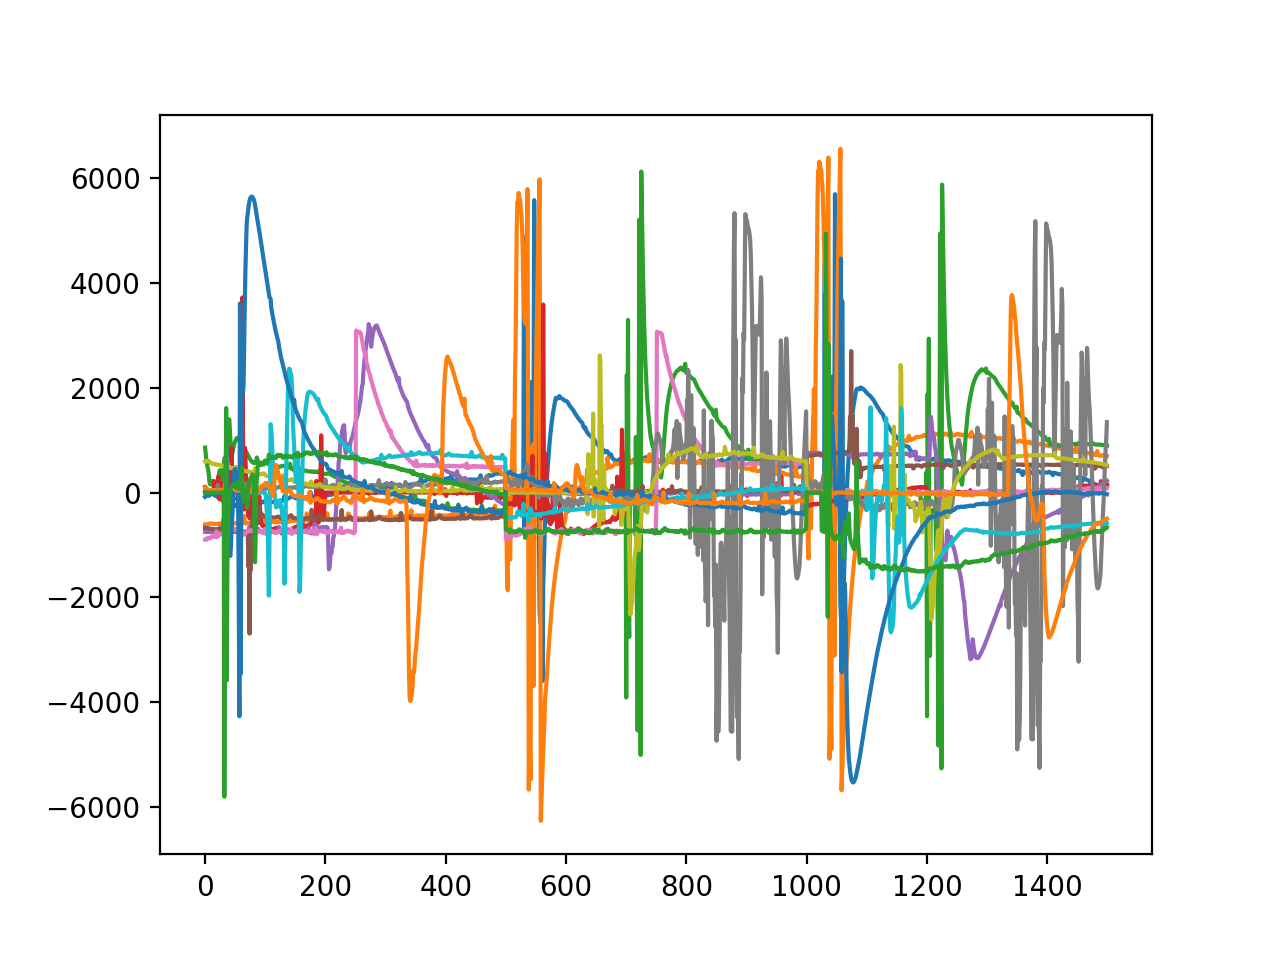

In [46]:
plt.close()
plt.plot(x[619, :])
plt.plot(x[868, :])
plt.plot(x[1291, :])
plt.plot(x[1338, :])
plt.plot(x[1422, :])
plt.plot(x[2933, :])
plt.plot(x[3602, :])
plt.plot(x[4530, :])
plt.plot(x[5224, :])
plt.plot(x[6065, :])
plt.plot(x[6321, :])
plt.plot(x[6856, :])
plt.plot(x[6995, :])
plt.show()

<IPython.core.display.Javascript object>


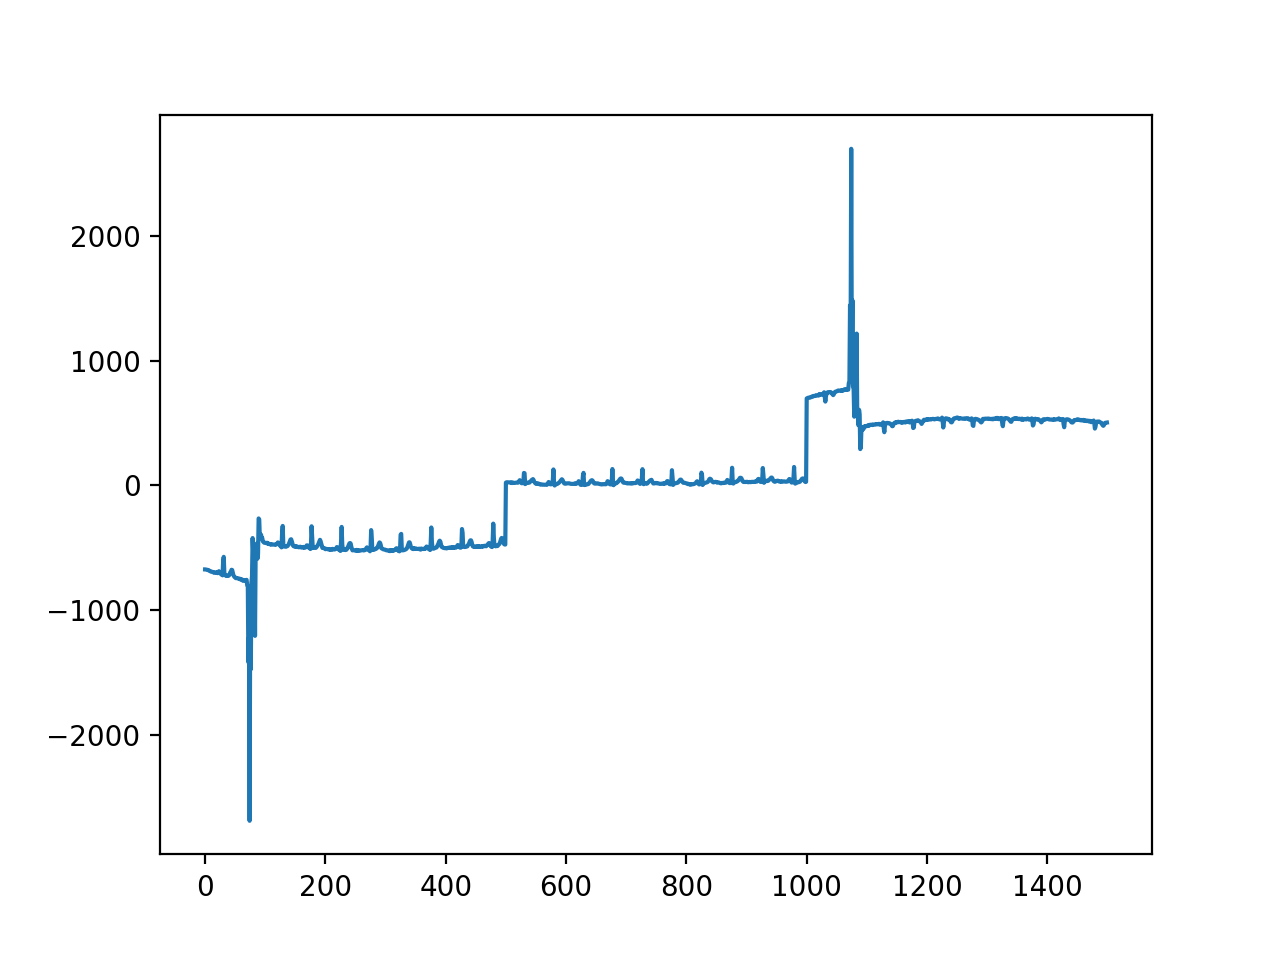

In [48]:
plt.close()
plt.plot(x[2933, 1001:1500])
plt.show()

<IPython.core.display.Javascript object>


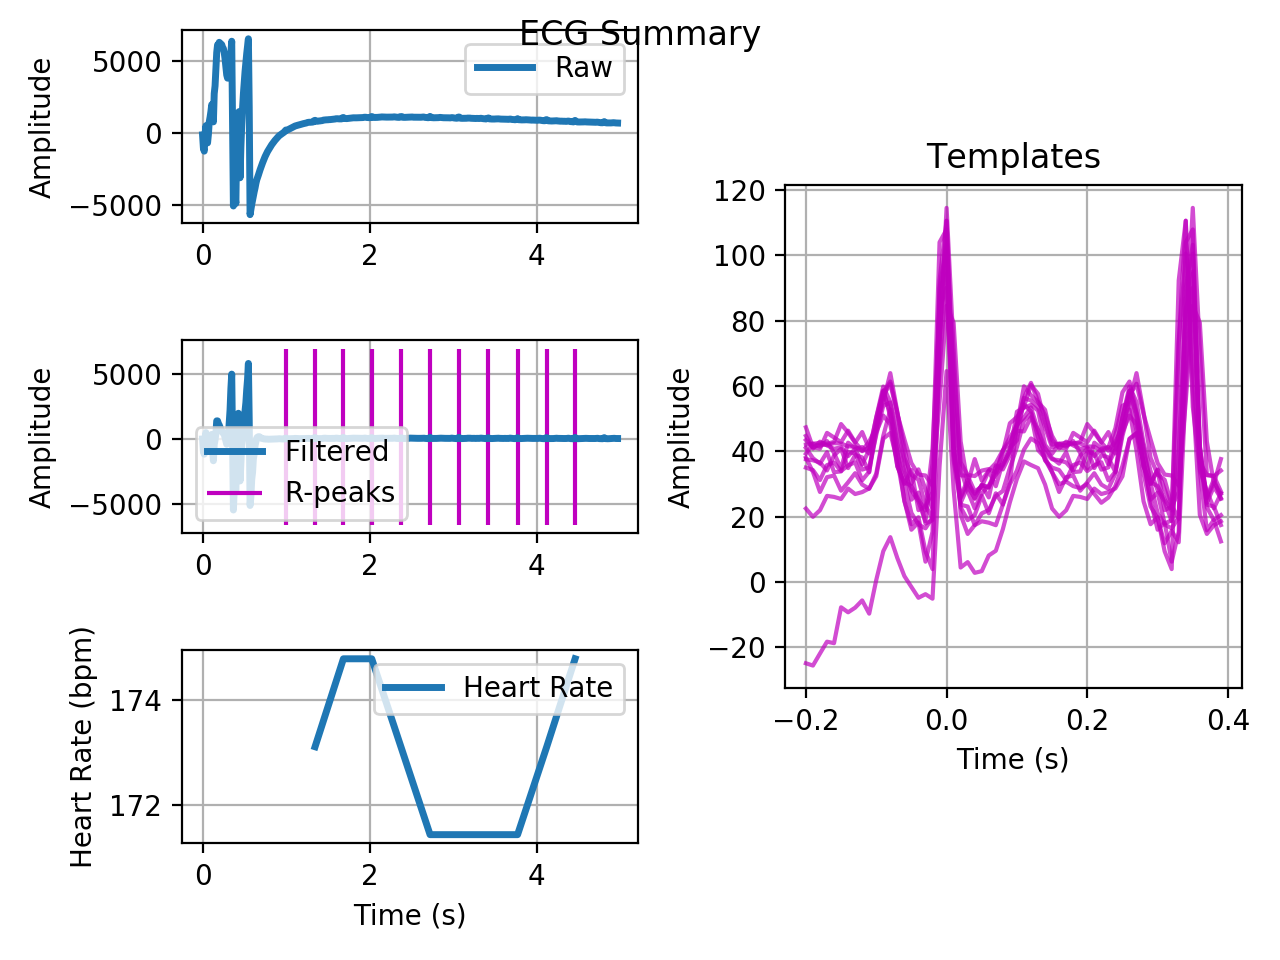

In [59]:
out_2933 = ecg.ecg(signal=x[868, 1001:1500], sampling_rate = 100., show=True)

<IPython.core.display.Javascript object>


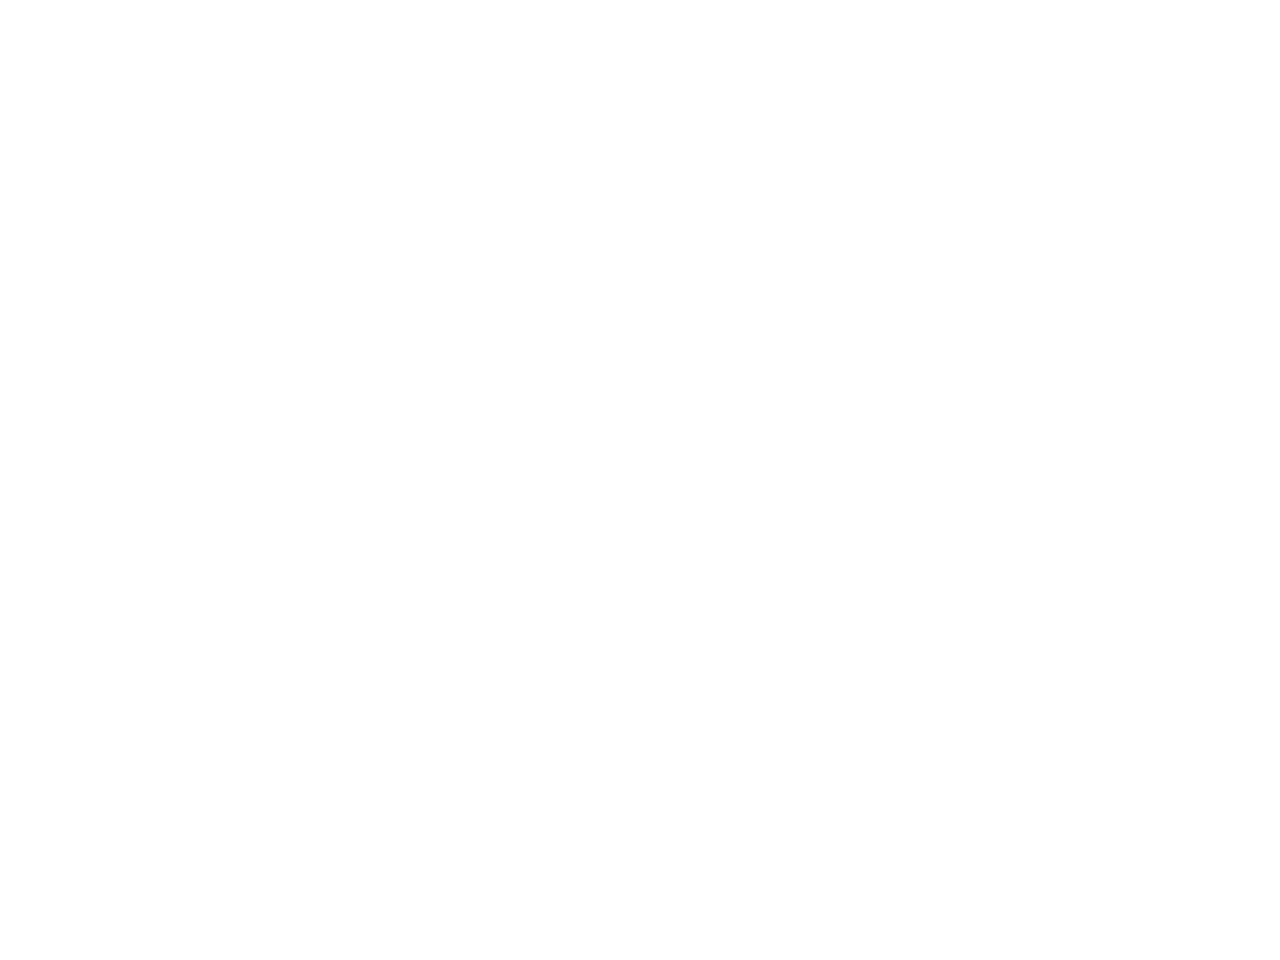

min 19.0 i 169
min 0.0 i 2297
max 156.0 i 4476
max 170.0 i 4530
min 0.0 i 4726


In [10]:
# about y
plt.close()
plt.scatter(range(y.shape[0]), y)
for i in range(y.shape[0]):
    if (y[i] > 150):
        print('max', y[i], 'i', i)
    if (y[i] < 20):
        print('min', y[i], 'i', i)
        
plt.show()

<IPython.core.display.Javascript object>


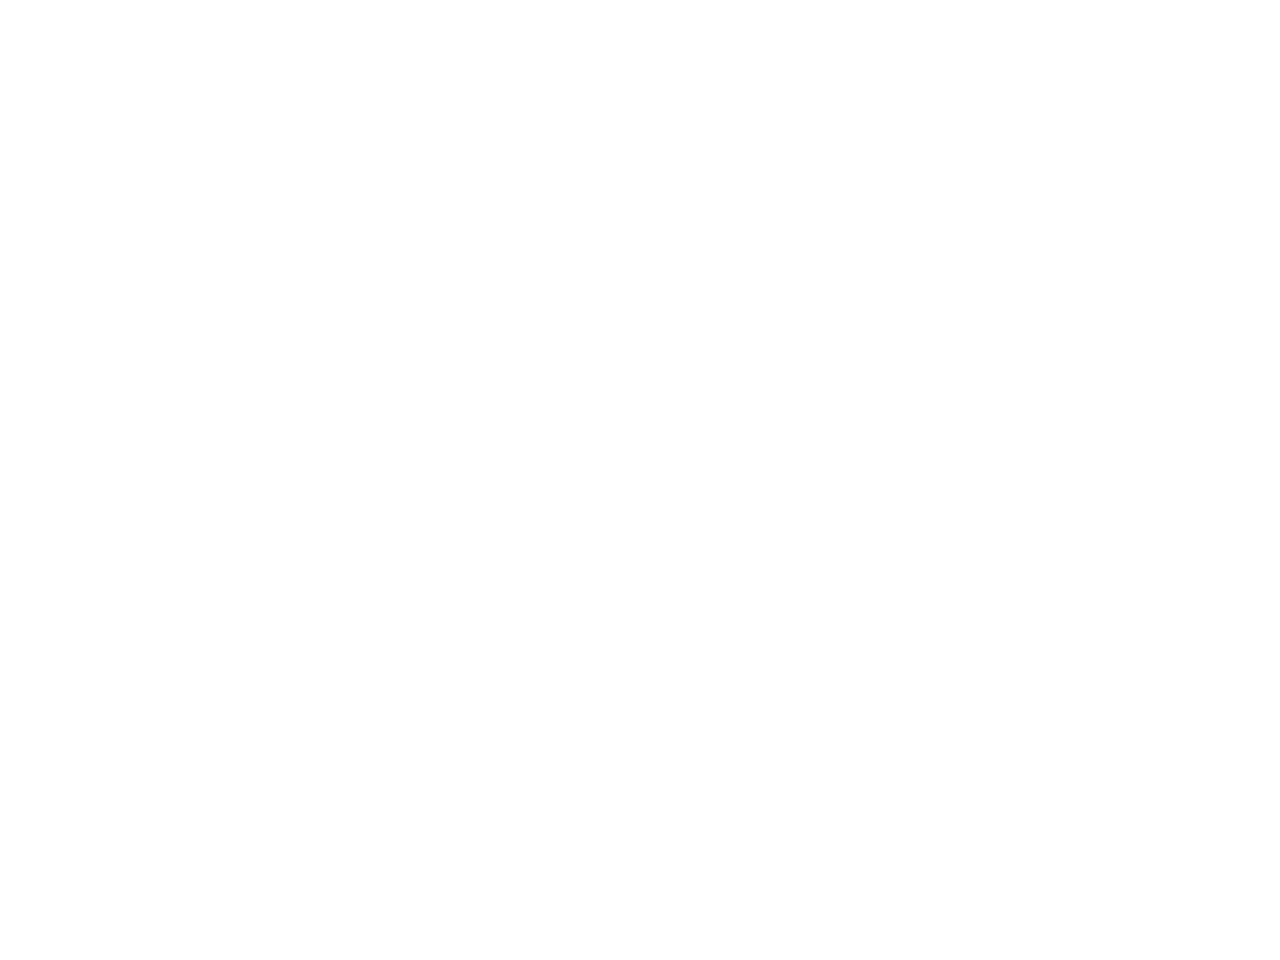

In [11]:
# y outlier below
plt.close()
plt.plot(x[2297, :])
plt.plot(x[4726, :])
plt.plot(x[169, :])

plt.show()

<IPython.core.display.Javascript object>


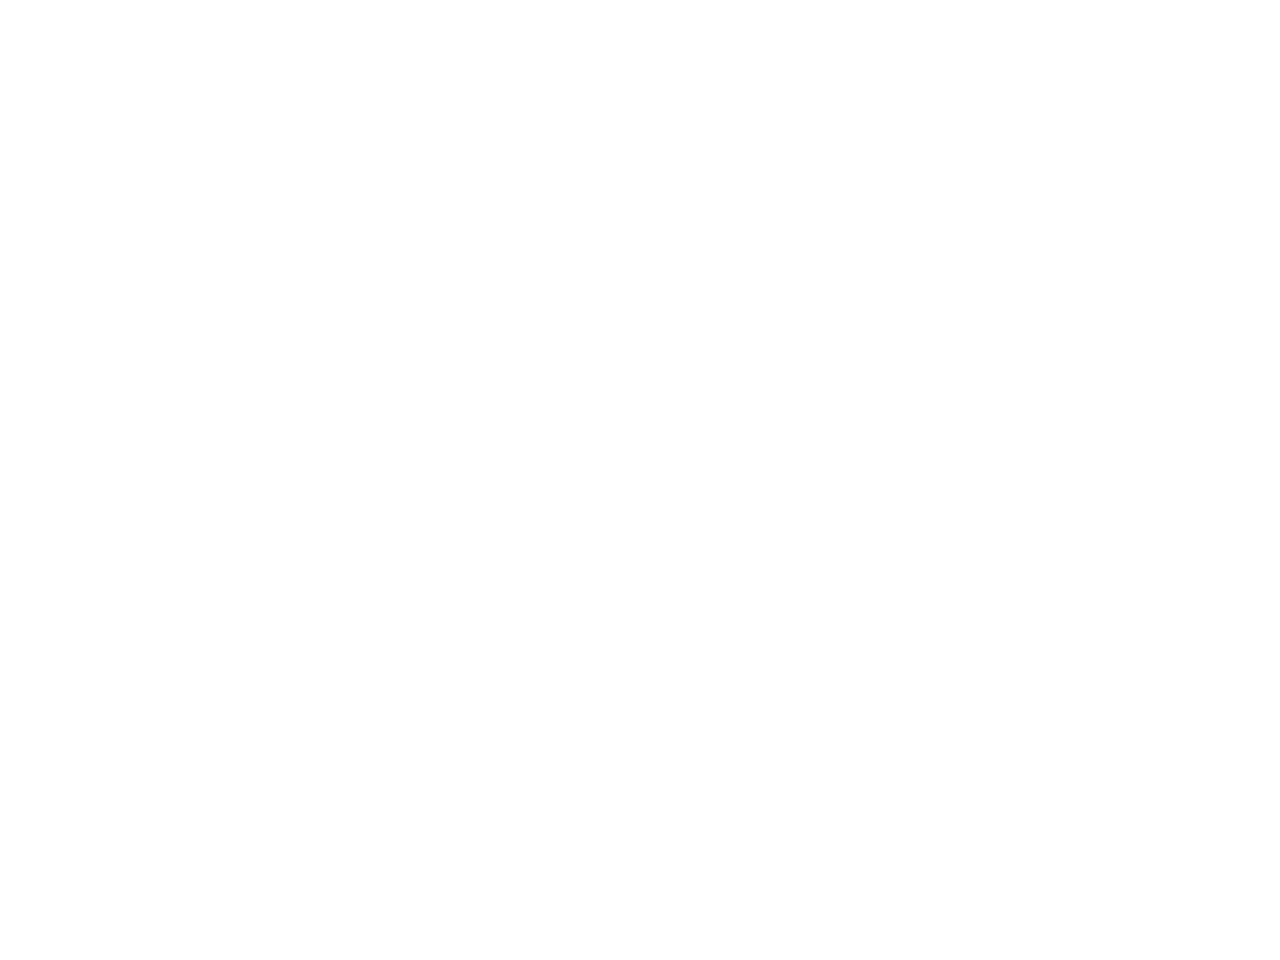

In [12]:
# y outlier above
plt.close()
plt.plot(x[4530, :])
plt.plot(x[4476, :])
plt.show()

In [13]:
# x outlier remove
zscore_of_x = np.abs(stats.zscore(x))
x_condition = np.copy(x)
x_condition[np.where(zscore_of_x <= 3)] = 0
x_condition[np.where(zscore_of_x > 3)] = 1
x_condition = np.sum(x_condition, axis=1)
x_outlier_x_removed = x[np.where(x_condition == 0)]
y_outlier_x_removed = y[np.where(x_condition == 0)]
print('train_x m, s: ', x_outlier_x_removed.mean(), x_outlier_x_removed.std())
print('train_x min, max: ', x_outlier_x_removed.min(), x_outlier_x_removed.max())
print('x_length : ', x_outlier_x_removed.shape[0])

train_x m, s:  2.715990964115872 103.92237946717952
train_x min, max:  -605.6 568.2
x_length :  6168


<IPython.core.display.Javascript object>


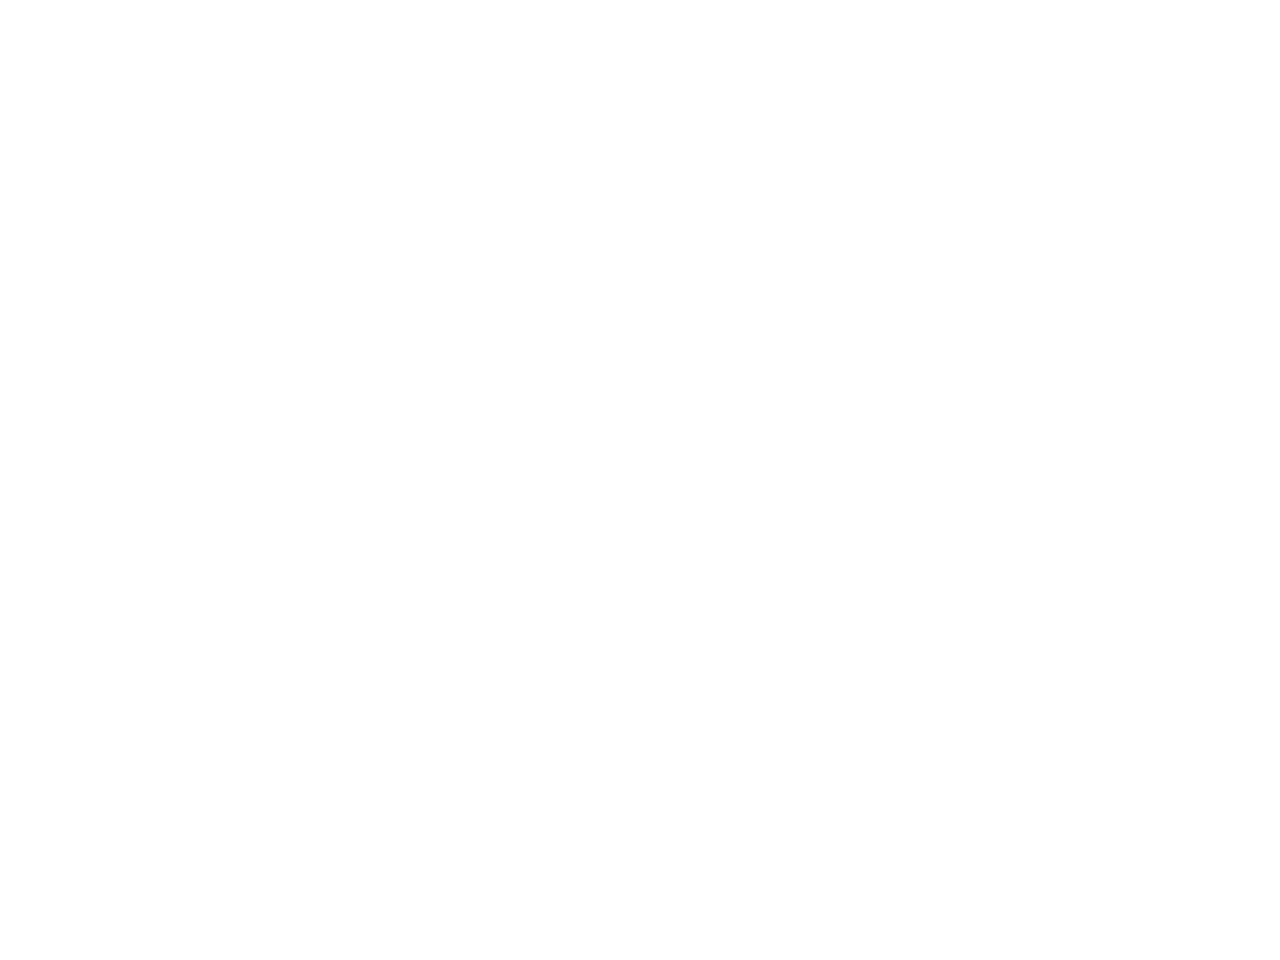

In [14]:
# plot all x_outlier_x_removed
plt.close()
for i in range(x_outlier_x_removed.shape[0]):
    plt.plot(x_outlier_x_removed[i, :])
    if i > 2000:
        break
plt.show()

In [15]:
from biosppy.signals import ecg

In [ ]:
plt.close()
for i in range(x_outlier_x_removed.shape[0]):
    out_x_removed = ecg.ecg(signal=x_outlier_x_removed[i, :], sampling_rate = 100., show=False)
    plt.plot(out_x_removed['filtered'])
    if i > 2000:
        break
        
plt.show()

<IPython.core.display.Javascript object>


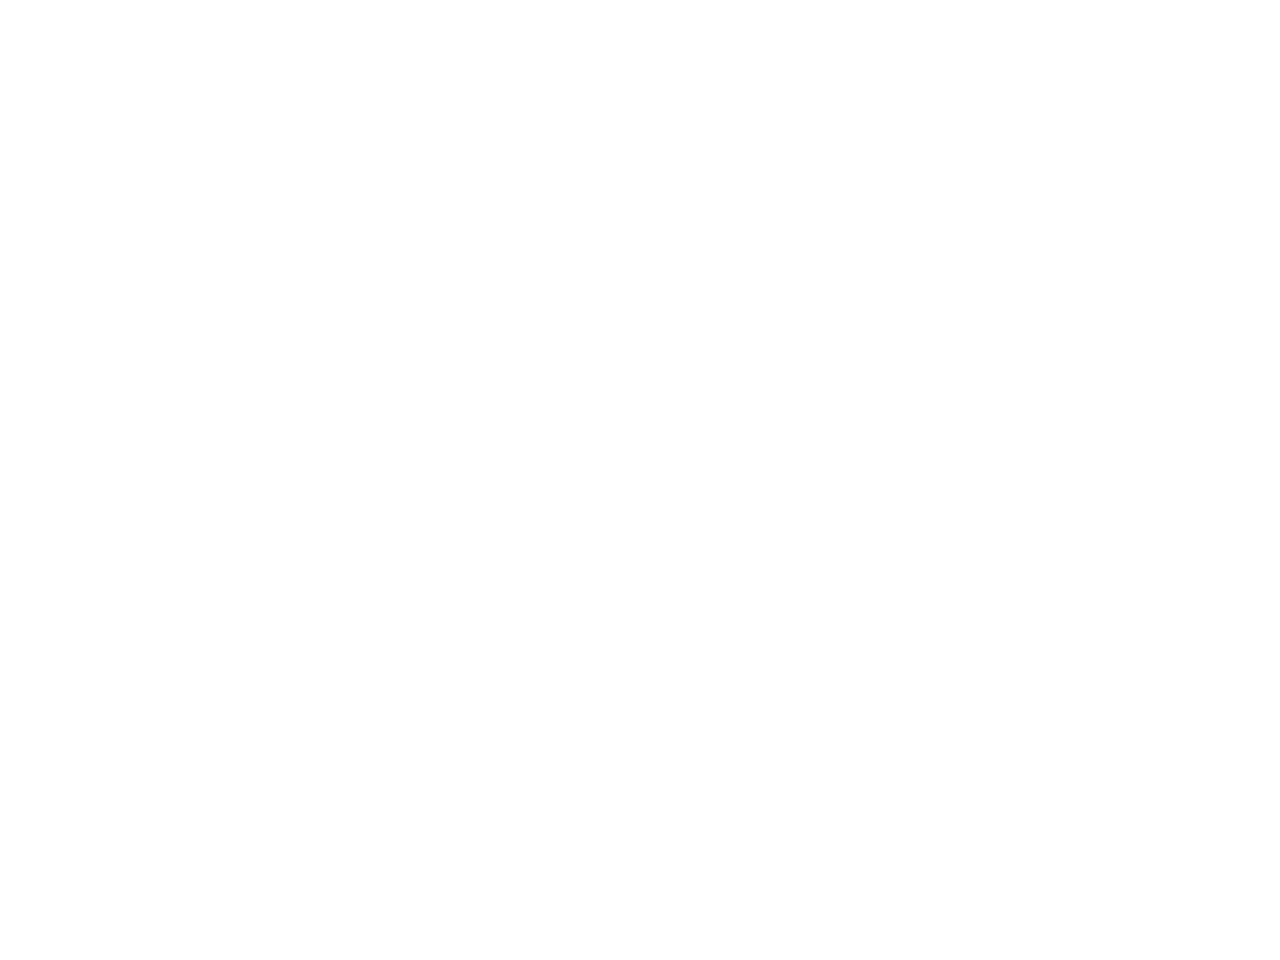

In [16]:
plt.close()
for i in range(x_outlier_x_removed.shape[0]):
    out_x_removed = ecg.ecg(signal=x_outlier_x_removed[i, :], sampling_rate = 100., show=False)
    plt.plot(out_x_removed['filtered'])
    if i > 2000:
        break
        
plt.show()

<IPython.core.display.Javascript object>


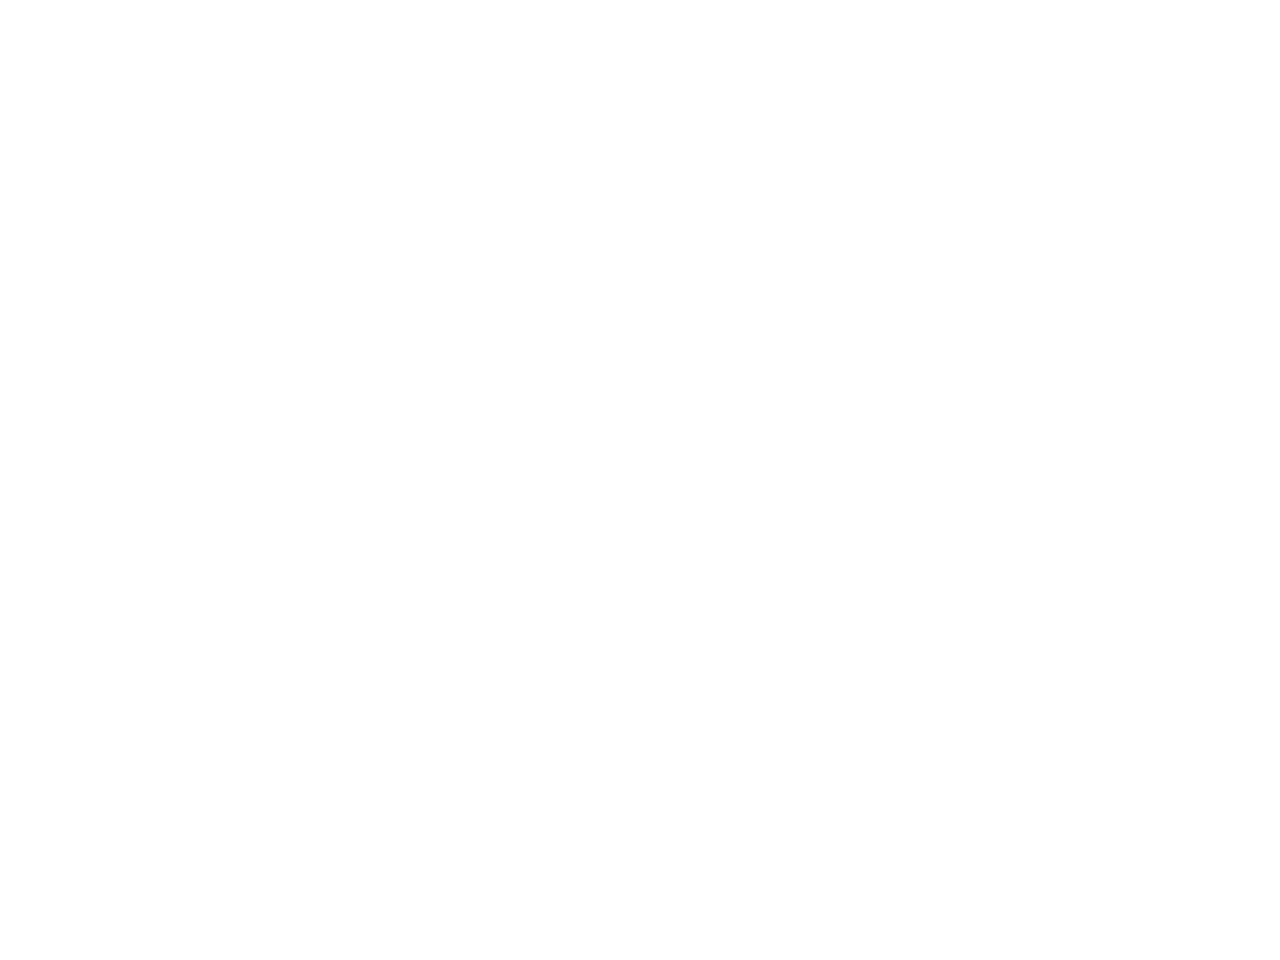

In [17]:
plt.close()
for i in range(x_outlier_x_removed.shape[0]):
    out_x_removed = ecg.ecg(signal=x_outlier_x_removed[i, :], sampling_rate = 100., show=False)
    plt.plot(out_x_removed['filtered'])
    if i > 2000:
        break
        
plt.show()

<IPython.core.display.Javascript object>


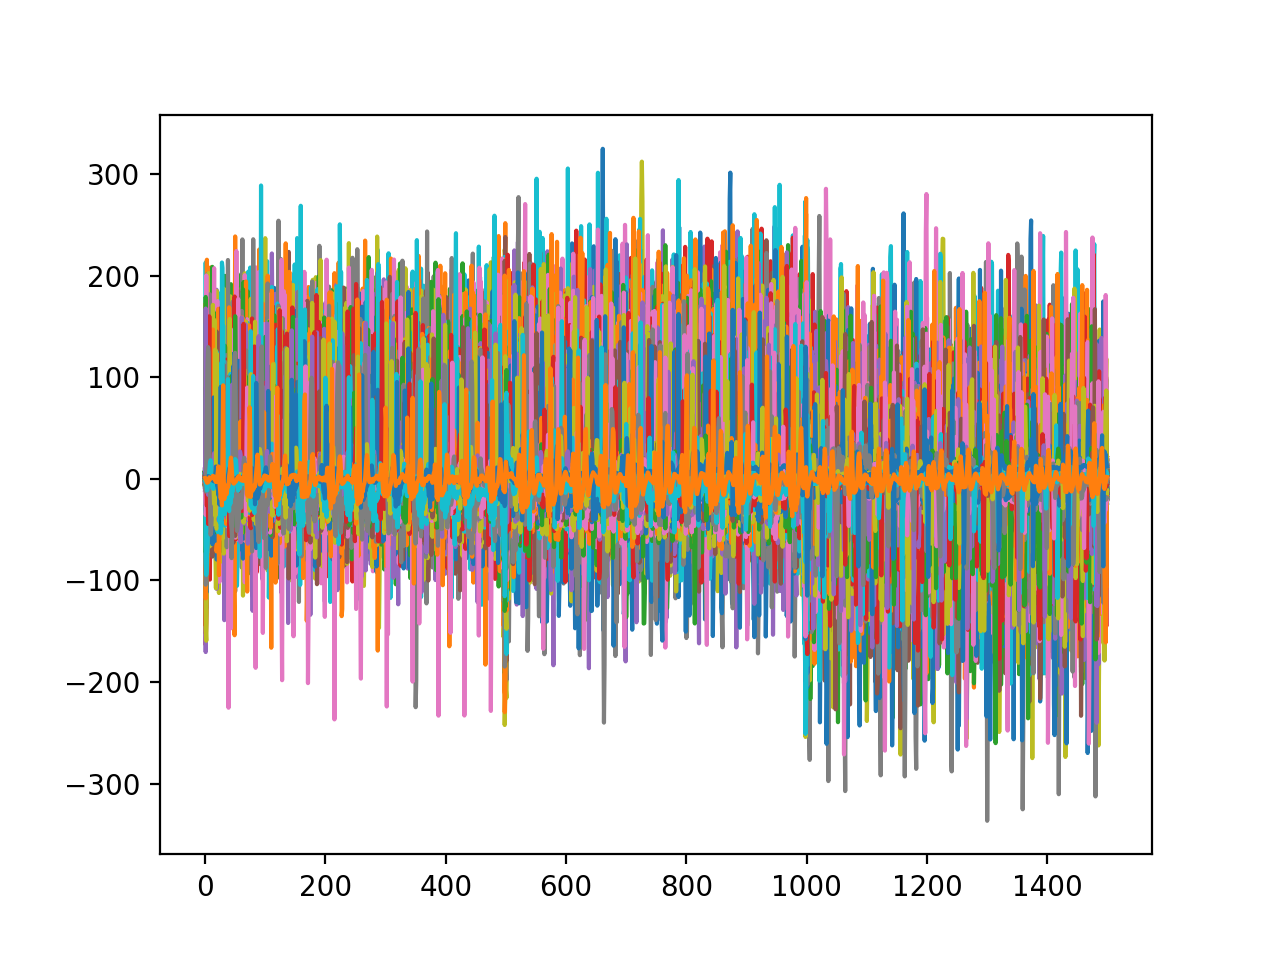

In [18]:
# add maxabs
plt.close()
for i in range(x_outlier_x_removed.shape[0]):
    out_x_removed = ecg.ecg(signal=x_outlier_x_removed[i, :], sampling_rate = 100., show=False)
    plt.plot(out_x_removed['filtered'])
    if i > 2000:
        break
plt.show()

<IPython.core.display.Javascript object>


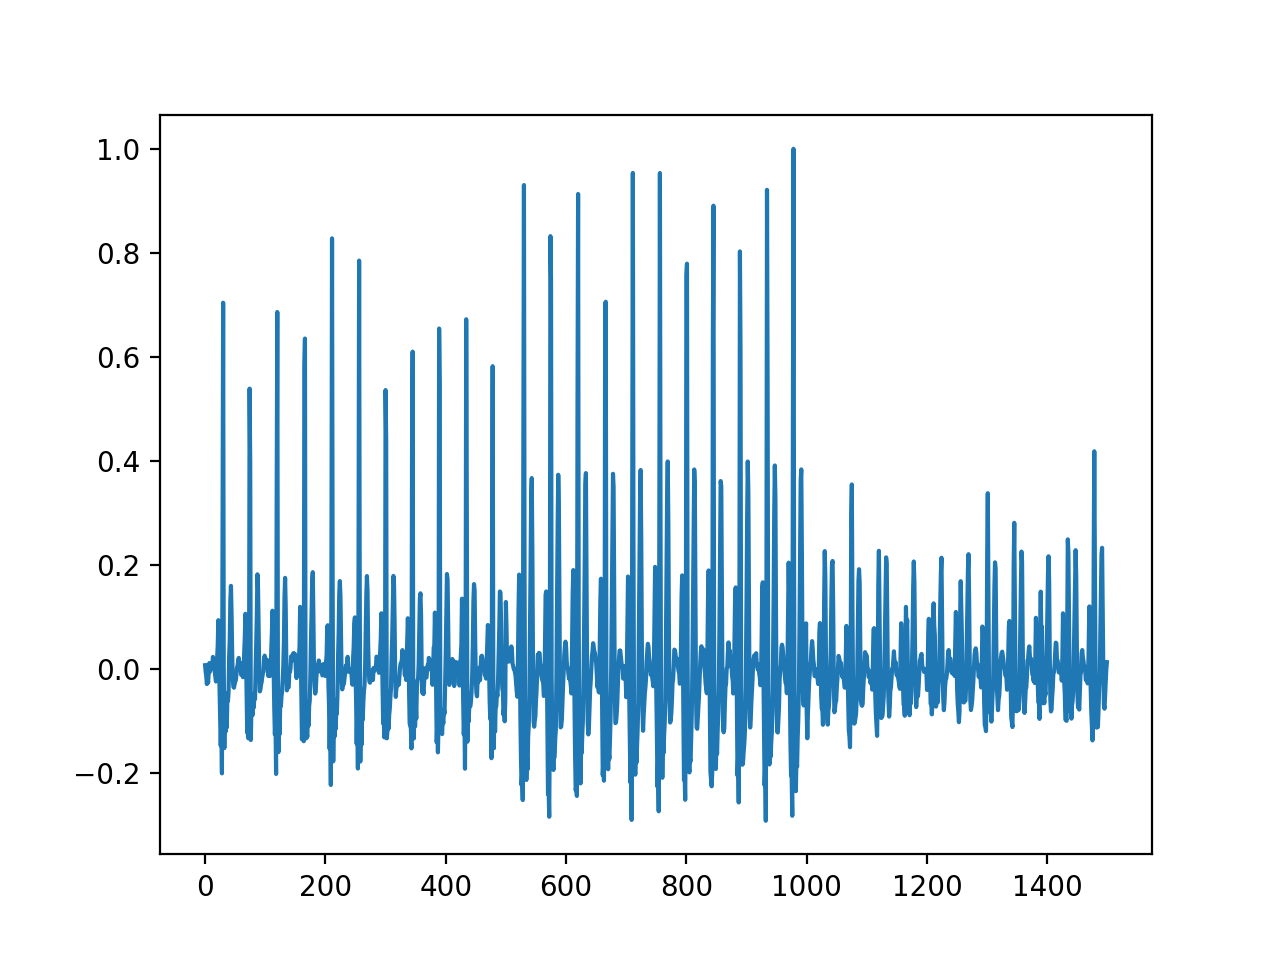

In [19]:
plt.close()
maxabs_x = scale_maxabs(out_x_removed['filtered'], np.max(np.abs(out_x_removed['filtered'])))
plt.plot(maxabs_x)
plt.show()